##6. Splitting of dataset

- Stratify splitting will be done as dataset is highly imbalanced 

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle
from sklearn.ensemble import StackingClassifier


####6.1. Importing the cleaned data

In [ ]:
from sklearn.model_selection import train_test_split
#reading the files and splitting the target
X=pd.read_csv('/content/drive/My Drive/Self Case study -1/final_data.csv')
#X=pd.read_csv('/content/final_data.csv')
X=X.drop(['Unnamed: 0'],axis=1)
y=X['target']
X=X.drop(['target'],axis=1)

#splitting into train,cv and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train,random_state=42)

In [ ]:
#printing the shapes of all the datasets.
print('X_train Shape : ',X_train.shape)
print('y_train Shape : ',y_train.shape)
print('X_cv Shape : ',X_cv.shape)
print('y_cv Shape : ',y_cv.shape)
print('X_test Shape : ',X_test.shape)
print('y_test Shape : ',y_test.shape)

X_train Shape :  (40800, 96)
y_train Shape :  (40800,)
X_cv Shape :  (7200, 96)
y_cv Shape :  (7200,)
X_test Shape :  (12000, 96)
y_test Shape :  (12000,)


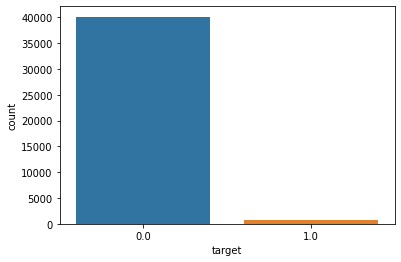

In [ ]:
# WE will check the imbalancement of the data 
ax=sns.countplot(x=y_train)
plt.show()

- As we have seen dataset is highly imbalanced.

####6.2.Using SMOTE and random-undersampling on train dataset to counter the imbalance 

In [ ]:
#using smote and randomundersampling!
over = SMOTE(sampling_strategy=0.2,random_state=24)
under = RandomUnderSampler(sampling_strategy=0.4,random_state=24)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X, y)
X_train=pd.DataFrame(X_train)
X_train.columns=X_cv.columns
y_train=pd.Series(y_train)

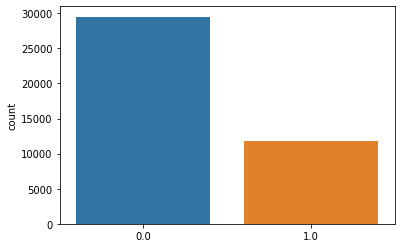

In [ ]:
# WE will check the imbalancement of the data 
ax=sns.countplot(x=y_train)
plt.show()

- Datapoints of minority class have increased using SMOTE and datapoints of majority class has decreased using random undersampling.

In [ ]:
print('X_train Shape : ',X_train.shape)
print('y_train Shape : ',y_train.shape)
print('X_cv Shape : ',X_cv.shape)
print('y_cv Shape : ',y_cv.shape)
print('X_test Shape : ',X_test.shape)
print('y_test Shape : ',y_test.shape)

X_train Shape :  (41300, 96)
y_train Shape :  (41300,)
X_cv Shape :  (7200, 96)
y_cv Shape :  (7200,)
X_test Shape :  (12000, 96)
y_test Shape :  (12000,)


####6.3. Normalizing the Dataset.

#####Why Normalizing??
- As we have seen the data in each features max value is very different. So we have to normalize.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler()
col=X_train.columns

#normalizing X_train
X_train=mm.fit_transform(X_train)
X_train=pd.DataFrame(X_train)
X_train.columns=col

#normalizing X_cv
X_cv=mm.transform(X_cv)
X_cv=pd.DataFrame(X_cv)
X_cv.columns=col

#normalizing X_test
X_test=mm.transform(X_test)
X_test=pd.DataFrame(X_test)
X_test.columns=col


- Shape of Train,CV and Test

In [ ]:
print('X_train Shape : ',X_train.shape)
print('y_train Shape : ',y_train.shape)
print('X_cv Shape : ',X_cv.shape)
print('y_cv Shape : ',y_cv.shape)
print('X_test Shape : ',X_test.shape)
print('y_test Shape : ',y_test.shape)

X_train Shape :  (41300, 96)
y_train Shape :  (41300,)
X_cv Shape :  (7200, 96)
y_cv Shape :  (7200,)
X_test Shape :  (12000, 96)
y_test Shape :  (12000,)


In [ ]:
def confusion_mx(test_y, predict_y):
    ''' Function to see Confusion,precision and recall matrix'''
    
    C1 = confusion_matrix(test_y, predict_y,normalize='true')   
    labels = [0,1]
    plt.figure(figsize=(20,4))
    cmap=sns.light_palette("yellow")
    
    plt.subplot(1, 4, 1)
    sns.heatmap(C1, annot=True, cmap=cmap, fmt=".4f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion matrix (Normalized)')

    C = confusion_matrix(test_y, predict_y)   
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    plt.subplot(1, 4, 2)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".4f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Confusion matrix')
    # representing A in heatmap format

    plt.subplot(1, 4, 3)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".4f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Precision matrix')
    
    # representing B in heatmap format
    plt.subplot(1, 4, 4)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".4f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title('Recall matrix')
    
    plt.show()
    return C
    

##7. Modelling:

- First, Linear classifier like Logistic regression,SVM will be trained on the raw feature dataset. Then we will use ensemble methods for classification. Important features can then be derived.

### 7.1.K-Nearest Neighbours :


F1 score for : 1 is 0.7817589576547231 
F1 score for : 3 is 0.6779661016949152 
F1 score for : 5 is 0.6380697050938339 
F1 score for : 7 is 0.6214099216710183 
F1 score for : 9 is 0.6010101010101011 
F1 score for : 11 is 0.5862068965517242 
F1 score for : 13 is 0.5790754257907543 

  Best alpha (hyperparameter) : 1 



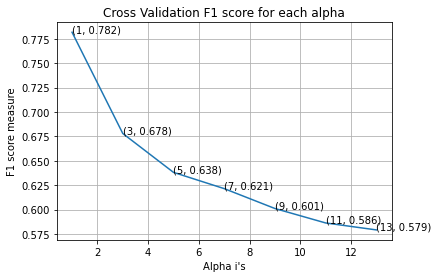


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  1.0
F1_score for cv data :  0.7817589576547231
F1_score for test data :  0.8048289738430584



Train Confusion Matrix: 


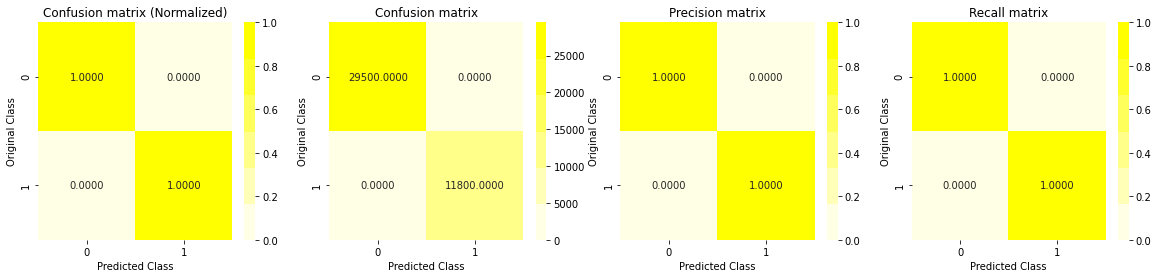



Test Confusion Matrix: 


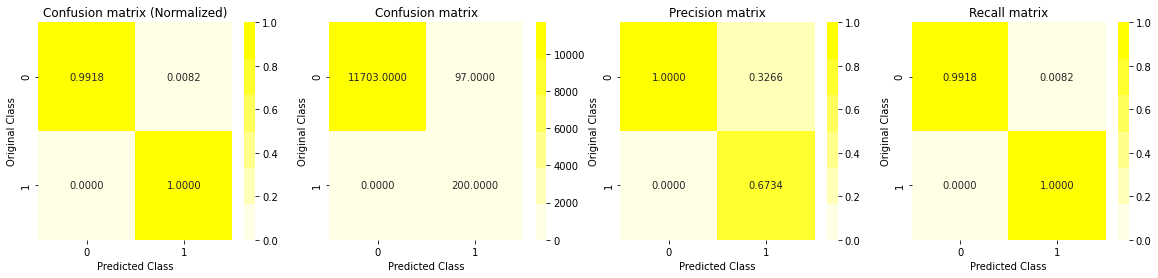

In [ ]:
#choosing the best hyperparameters
alpha = [x for x in range(1, 15, 2)]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    KNN=KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    KNN.fit(X_train,y_train)
    predict_y = KNN.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters    
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_KNN = np.argmax(cv_f1score_array) 


print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_KNN]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots() #returning a tuple of fig and axes

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array) 
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
KNN=KNeighborsClassifier(n_neighbors=alpha[best_alpha_KNN],n_jobs=-1)
KNN.fit(X_train, y_train)

#predicting actual labels
pred_y=KNN.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = KNN.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = KNN.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = KNN.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
KNN_c=confusion_mx(y_test,pred_y_test)
KNN_mcr=((KNN_c[1][0] +KNN_c[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',KNN_mcr)

Misclassification rate :  0.8083333333333333


### 7.2. Logistic Regression :


F1 score for : 1e-05 is 0.4564705882352941 
F1 score for : 0.0001 is 0.4564705882352941 
F1 score for : 0.001 is 0.46555819477434685 
F1 score for : 0.01 is 0.4891041162227603 
F1 score for : 0.1 is 0.5347043701799487 
F1 score for : 1 is 0.5885714285714286 
F1 score for : 10 is 0.6579804560260587 
F1 score for : 100 is 0.6879432624113475 

  Best (hyperparameter) : 100 



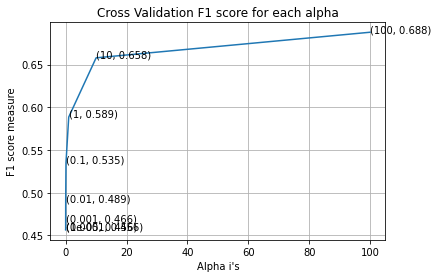


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9119553474972991
F1_score for cv data :  0.6879432624113475
F1_score for test data :  0.6653386454183267



Train Confusion Matrix: 


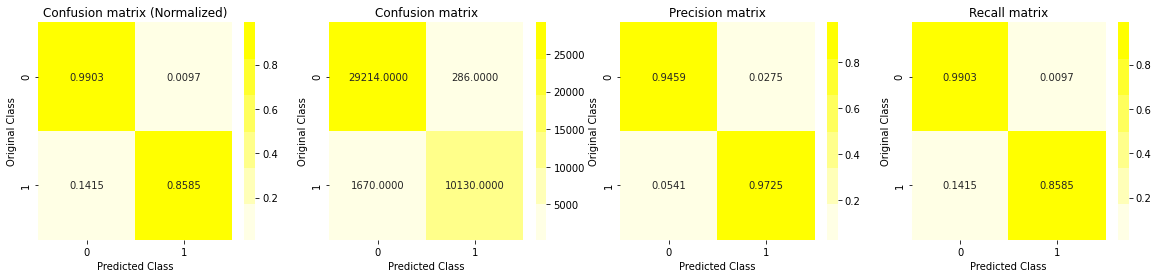



Test Confusion Matrix: 


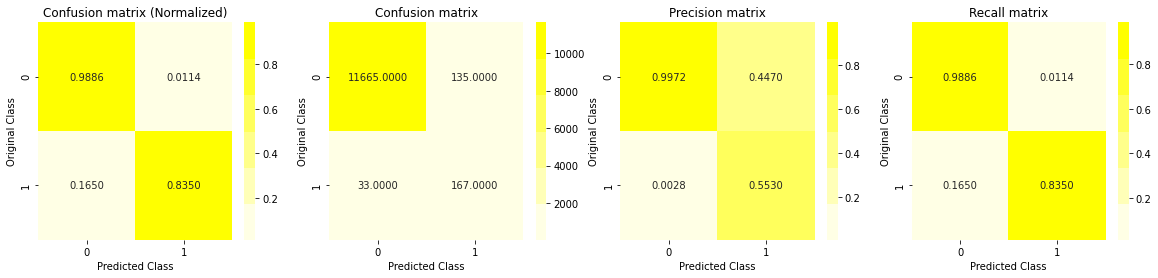

In [ ]:
#choosing the best hyperparameters
alpha = [10 ** x for x in range(-5, 3)]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced',n_jobs=-1)
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid",cv=3)
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_LR = np.argmax(cv_f1score_array)

print( '\n  Best (hyperparameter) :',alpha[best_alpha_LR]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha_LR],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid",cv=3)
sig_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=sig_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = sig_clf.predict(X_train)
LR_f1_tr=f1_score(y_train, pred_y_train,average='binary' )
print ('F1 score for train data : ',LR_f1_tr)
pred_y_cv = sig_clf.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf.predict(X_test)
LR_f1_te=f1_score(y_test, pred_y_test, average='binary')
print ('F1_score for test data : ',LR_f1_te)

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
LR_c=confusion_mx(y_test,pred_y_test)
LR_mcr=((LR_c[1][0] +LR_c[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',LR_mcr)

Misclassification rate :  1.4000000000000001


-- Let us see important features of Logistic Regression.


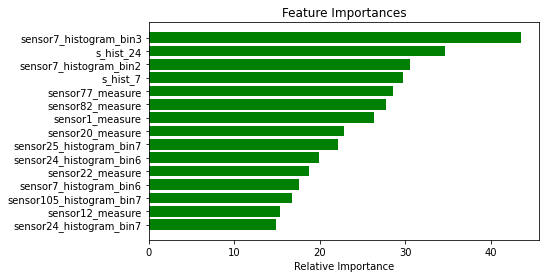

In [ ]:
features=X_train.columns
importances=abs(logisticR.coef_[0])
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(7,4))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 7.3. Support Vector Machines :


F1 score for : 0.0001 is 0.5141509433962265 
F1 score for : 0.001 is 0.45454545454545453 
F1 score for : 0.1 is 0.5284280936454848 
F1 score for : 1 is 0.03278688524590164 
F1 score for : 10 is 0.03278688524590164 
F1 score for : 100 is 0.0 

  Best alpha (hyperparameter) : 0.1 





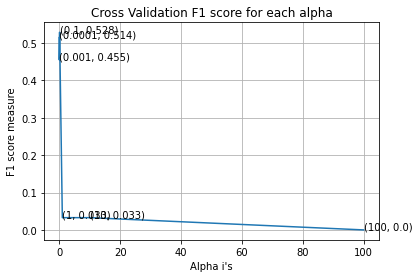


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.7295192607205897
F1_score for cv data :  0.5284280936454848
F1_score for test data :  0.502970297029703



Train Confusion Matrix: 


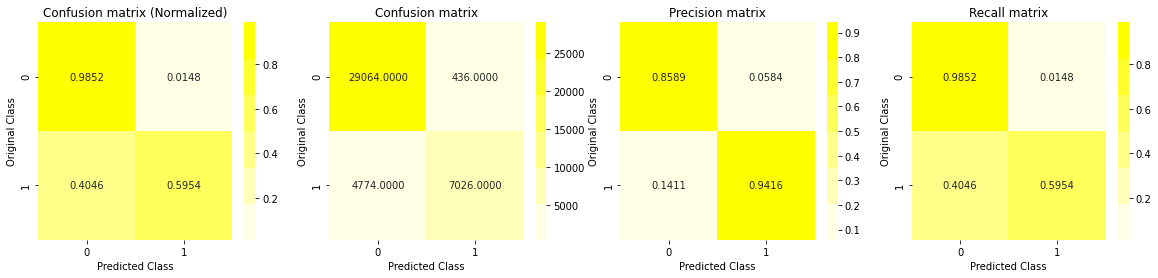



Test Confusion Matrix: 


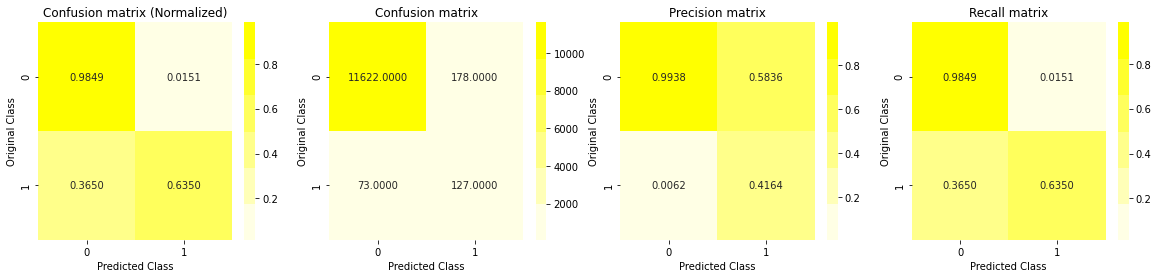

In [ ]:
#choosing the best hyperparameters

alpha = [0.0001, 0.001, 0.1, 1, 10, 100]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    SVM= SGDClassifier(alpha=i,loss='hinge',class_weight='balanced')
    SVM.fit(X_train,y_train)
    predict_y = SVM.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_SVM = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_SVM]  ,'\n')
print('\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
SVM=SGDClassifier(alpha=alpha[best_alpha_SVM],loss='hinge',class_weight='balanced')
SVM.fit(X_train, y_train)

#predicting actual labels

print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = SVM.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = SVM.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = SVM.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
svm_c=confusion_mx(y_test,pred_y_test)
SVM_mcr=((svm_c[1][0] +svm_c[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',SVM_mcr)

Misclassification rate :  2.091666666666667


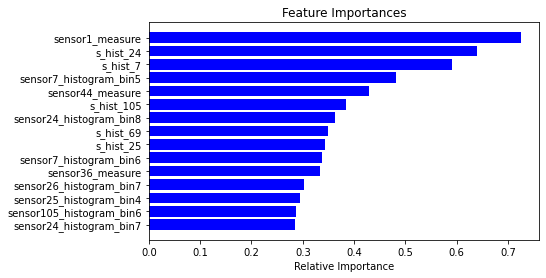

In [ ]:
#knowing the feature importances.
features=X_train.columns
importances=abs(SVM.coef_[0])
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(7,4))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 7.4. Random Forest :


F1 score for : 10 is 0.9022556390977443 
F1 score for : 50 is 0.8921933085501859 
F1 score for : 100 is 0.888888888888889 
F1 score for : 500 is 0.8823529411764706 
F1 score for : 1000 is 0.8759124087591241 

----------------------- best alpha selected ----------------------------- 



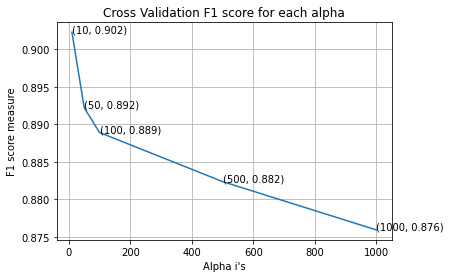


  Best alpha (hyperparameter) : 10 


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.999364164299945
F1_score for cv data :  0.9022556390977443
F1_score for test data :  0.8658008658008659



Train Confusion Matrix: 


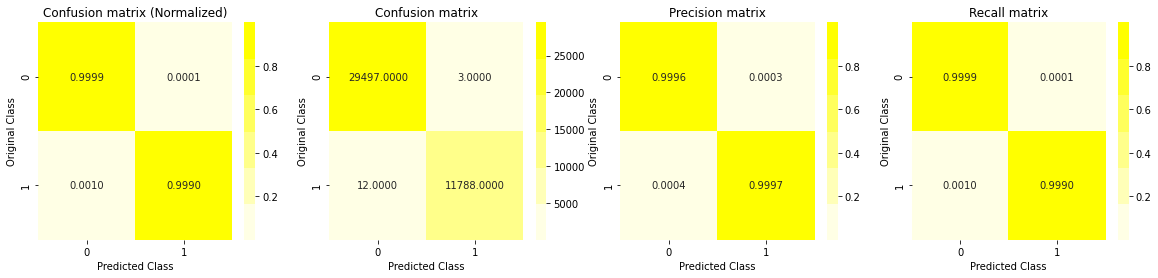



Test Confusion Matrix: 


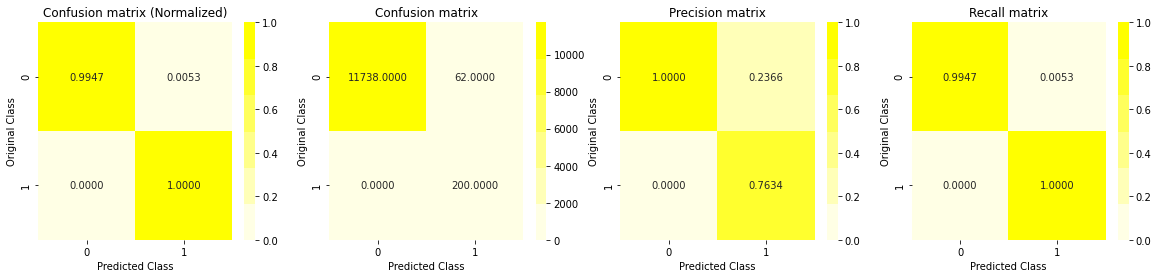

In [ ]:
#choosing the best hyperparameters

alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    predict_y = r_cfl.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_RF = np.argmax(cv_f1score_array)

print( '\n----------------------- best alpha selected ----------------------------- \n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha_RF],random_state=42,n_jobs=-1)
r_cfl.fit(X_train, y_train)

#predicting actual labels
pred_y=r_cfl.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_RF]  ,'\n')
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = r_cfl.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = r_cfl.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = r_cfl.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
r_cfl_c=confusion_mx(y_test,pred_y_test)
r_cfl_mcr=((r_cfl_c[1][0] +r_cfl_c[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',r_cfl_mcr)

Misclassification rate :  0.5166666666666666


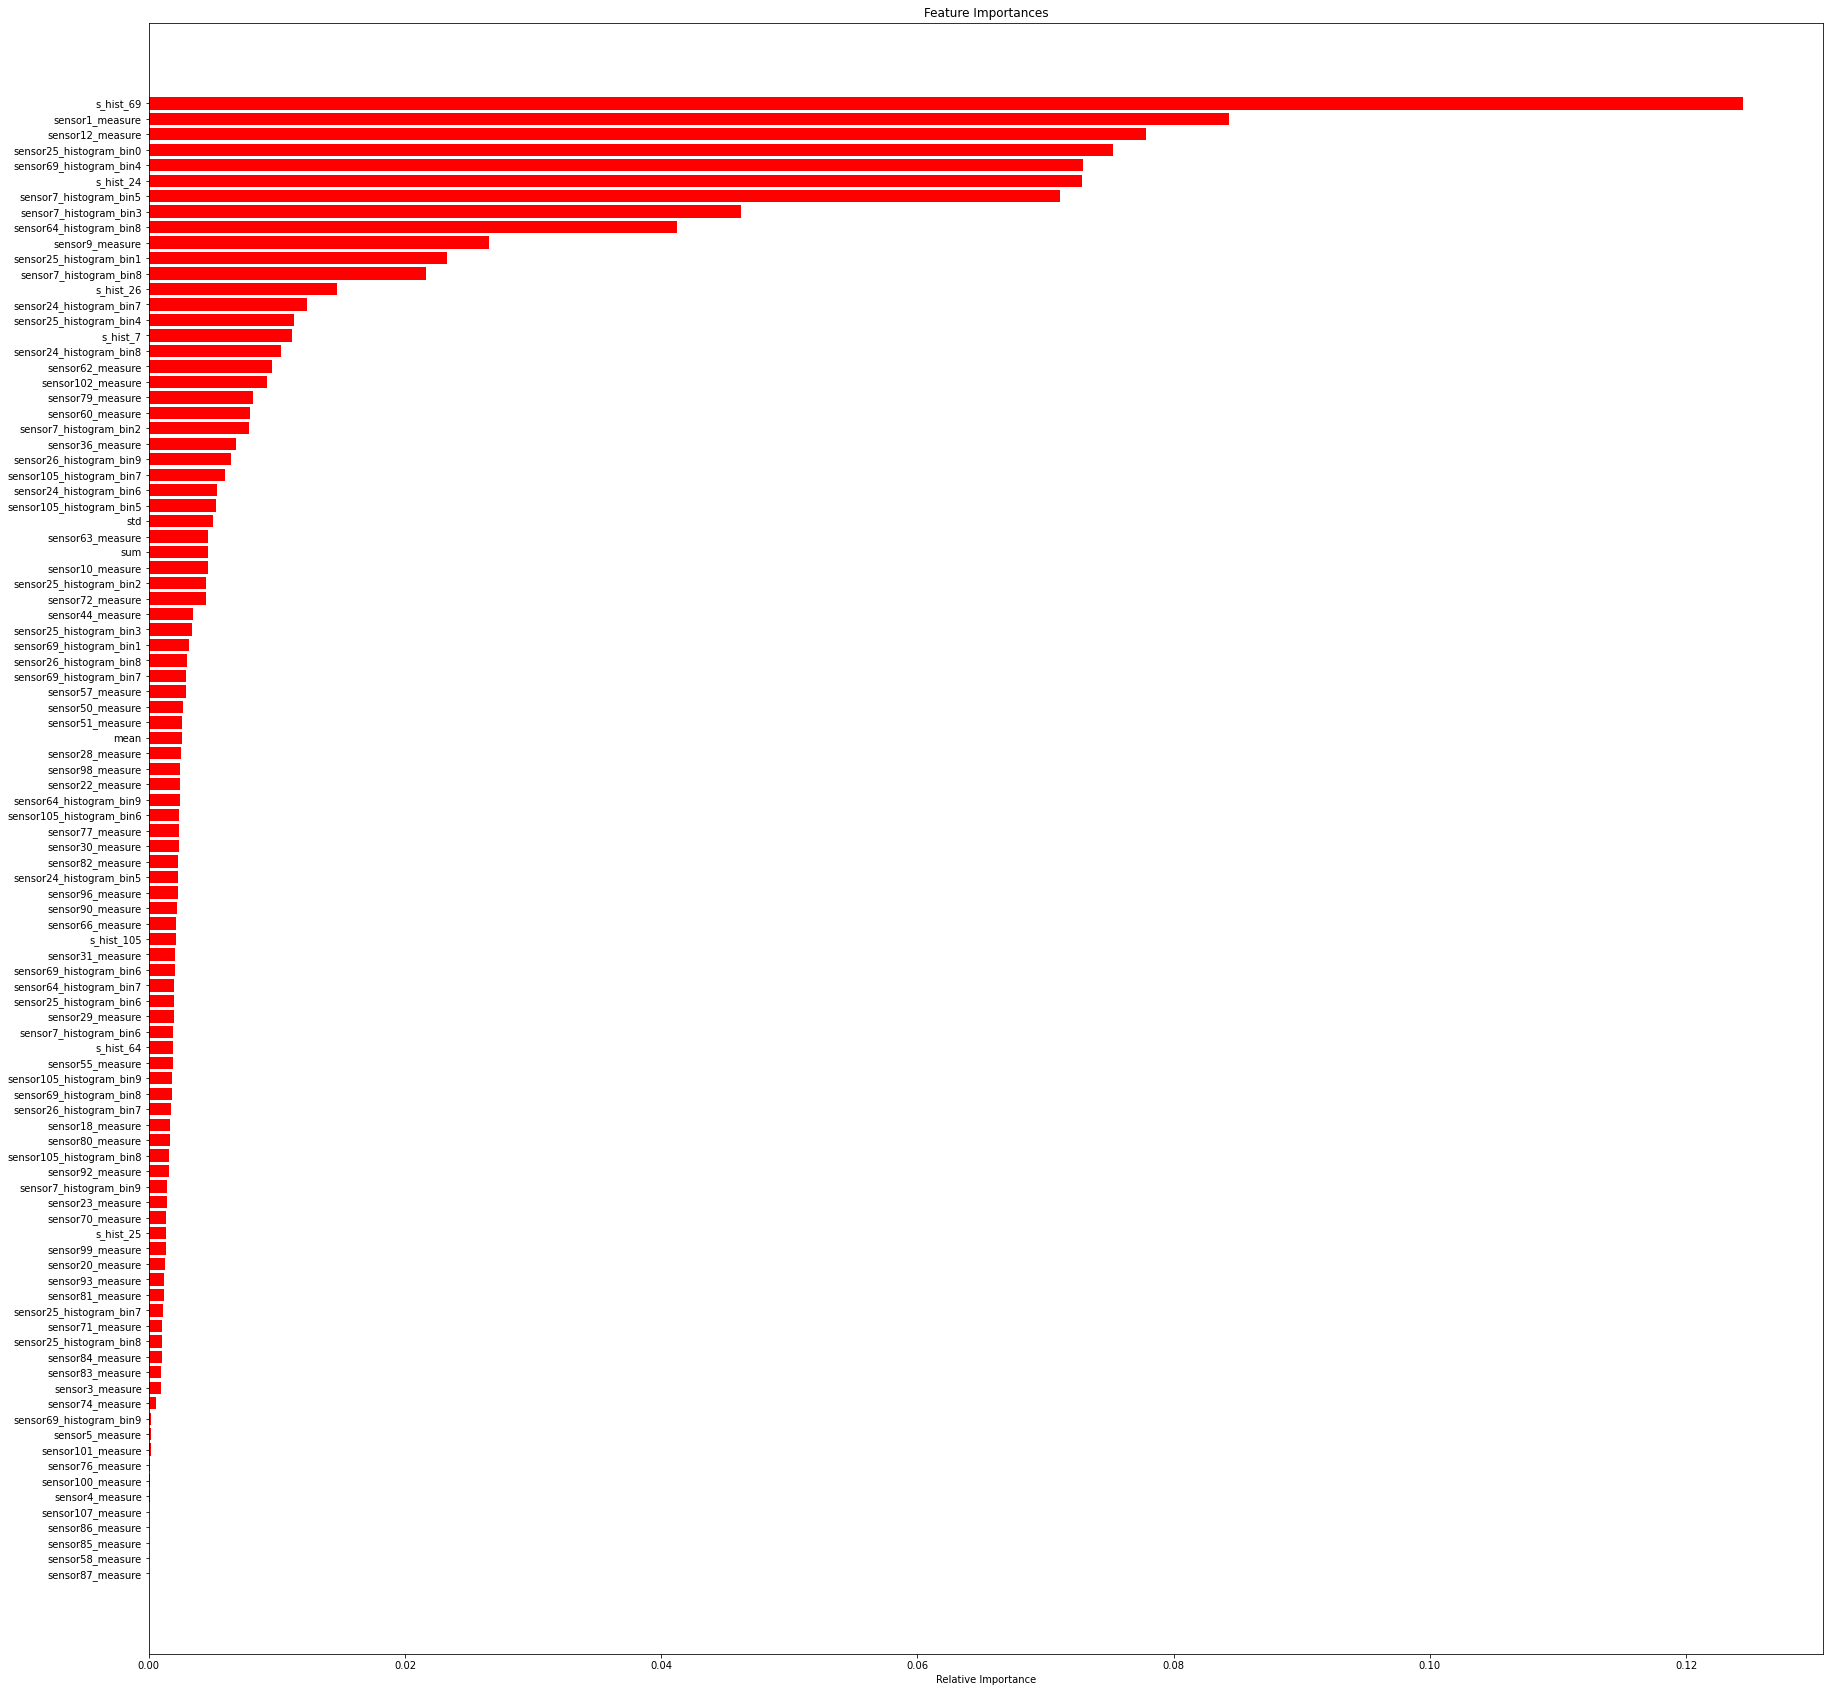

In [ ]:
features = X_train.columns
importances = r_cfl.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize=(30,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


- Checking if any feature has zero importance in the modelling.

In [ ]:
importances = r_cfl.feature_importances_
c=0
for i in importances:
    if i==0:
        c+=1
print('The no. features which have 0 feature importance : ',c)

The no. features which have 0 feature importance :  2


####7.4.1. Random Forest with Important Features:
- There are only 2 features which have zero importances, but we will also remove some featuers which have neglible feature importances.

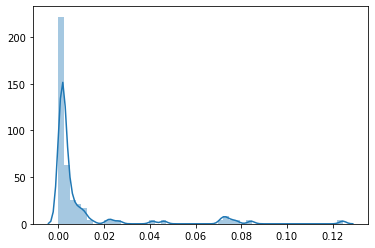

In [ ]:
import seaborn as sns
ax = sns.distplot(importances)
plt.show()

- Removing last 35 features:


In [ ]:
features = X_train.columns
importances = r_cfl.feature_importances_
indices = (np.argsort(importances))[:35]
rem_feat=[]
for i in indices:
    rem_feat.append(features[i]) 

#removing the least important features.
X_tr_rf=X_train.drop(rem_feat,axis=1)
X_cv_rf=X_cv.drop(rem_feat,axis=1)
X_te_rf=X_test.drop(rem_feat,axis=1)


F1 score for : 10 is 0.8856088560885608 
F1 score for : 50 is 0.8823529411764706 
F1 score for : 100 is 0.8791208791208792 
F1 score for : 500 is 0.8823529411764706 
F1 score for : 1000 is 0.8791208791208792 

----------------------- best alpha selected ----------------------------- 



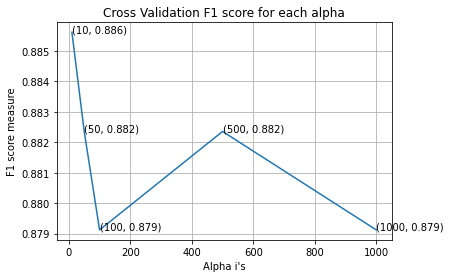


  Best alpha (hyperparameter) : 10 


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9992369001187045
F1_score for cv data :  0.8856088560885608
F1_score for test data :  0.8791208791208792



Train Confusion Matrix: 


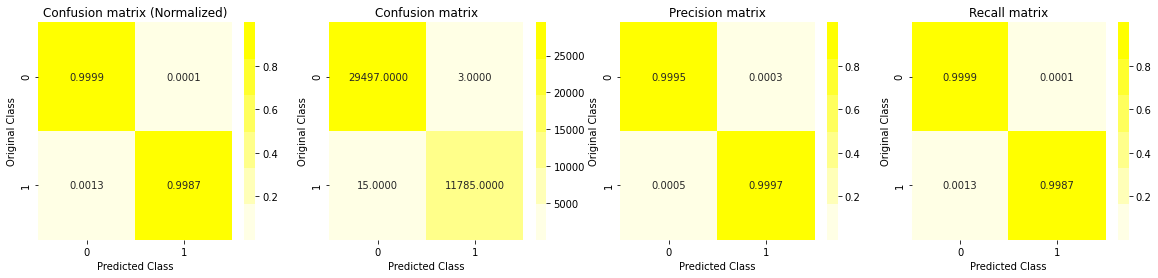



Test Confusion Matrix: 


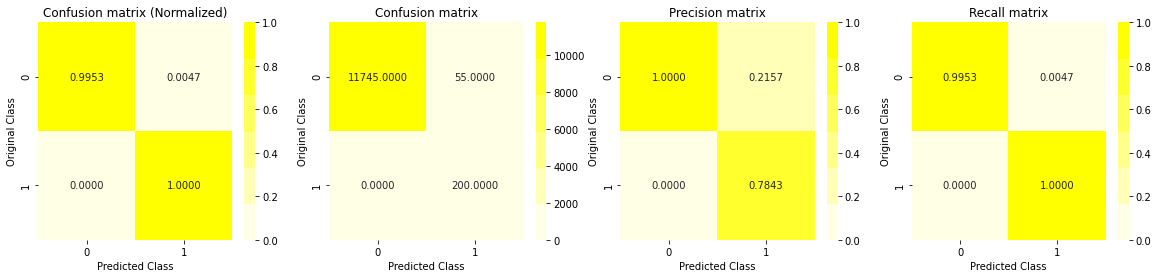

In [ ]:
#choosing the best hyperparameters

alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    r_clf=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_clf.fit(X_tr_rf,y_train)
    predict_y = r_clf.predict(X_cv_rf)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_RF_i = np.argmax(cv_f1score_array)

print( '\n----------------------- best alpha selected ----------------------------- \n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
r_clf=RandomForestClassifier(n_estimators=alpha[best_alpha_RF_i],random_state=42,n_jobs=-1)
r_clf.fit(X_tr_rf, y_train)

#predicting actual labels
pred_y=r_clf.predict(X_te_rf)

#displaying the perfomance metric for train,cv and test data
print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_RF_i]  ,'\n')
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = r_clf.predict(X_tr_rf)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = r_clf.predict(X_cv_rf)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = r_clf.predict(X_te_rf)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
r_clf_ci=confusion_mx(y_test,pred_y_test)
r_clf_mcri=((r_clf_ci[1][0] +r_clf_ci[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',r_clf_mcri)

Misclassification rate :  0.4583333333333333


##7.5. Voting Classifier:



 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9995761634313809
F1_score for cv data :  0.8480565371024735
F1_score for test data :  0.8333333333333333



Train Confusion Matrix: 


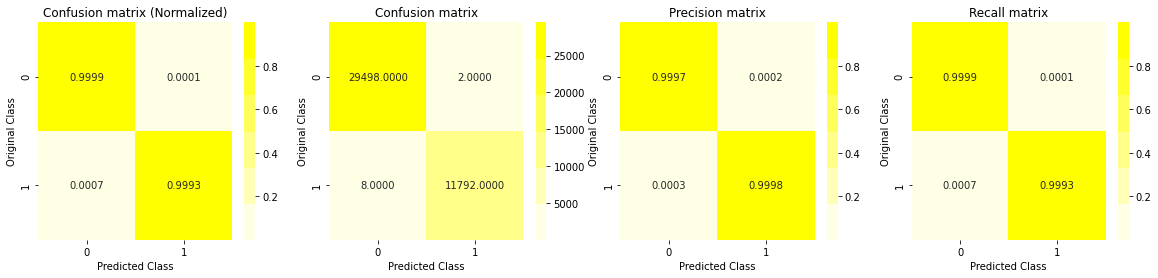



Test Confusion Matrix: 


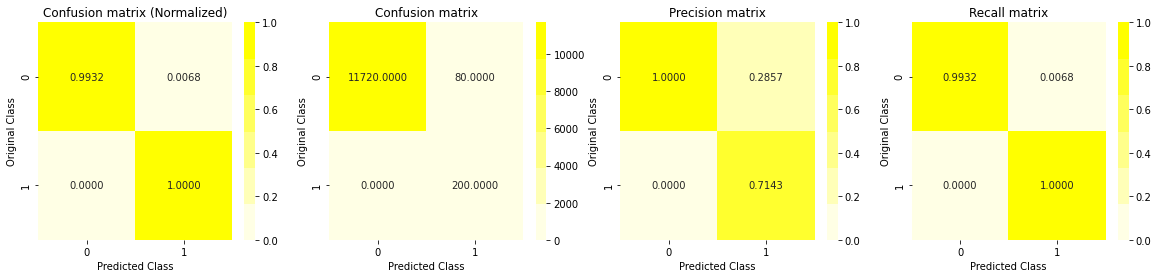

In [ ]:
from sklearn.ensemble import VotingClassifier
v_clf = VotingClassifier(
    estimators=[('lr', logisticR), ('rf', r_cfl), ('KNN', KNN)],
    voting='hard',n_jobs=-1)

v_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=v_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = v_clf.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = v_clf.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = v_clf.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
v_clf_c=confusion_mx(y_test,pred_y_test)
v_clf_mcr=((v_clf_c[1][0] +v_clf_c[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',v_clf_mcr)

Misclassification rate :  0.6666666666666667


###7.5.1. Voting Classifier with Important features






  Best alpha (hyperparameter) : 10 


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9993641103904362
F1_score for cv data :  0.8362369337979094
F1_score for test data :  0.8350730688935282



Train Confusion Matrix: 


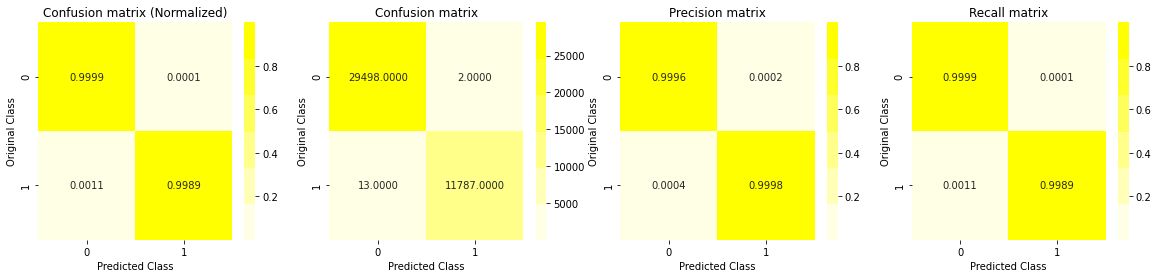



Test Confusion Matrix: 


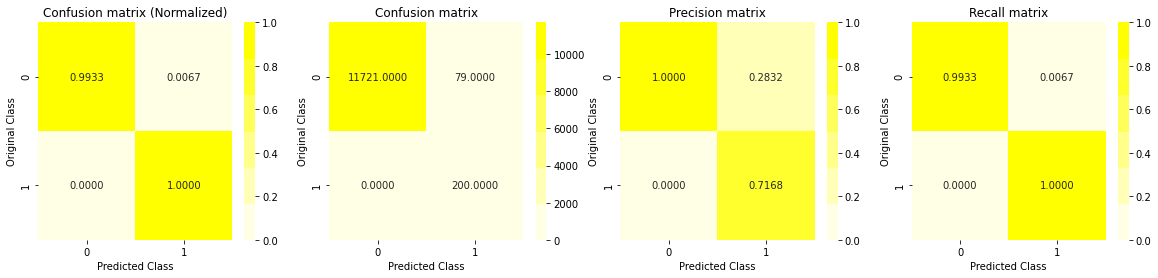

In [ ]:
from sklearn.ensemble import VotingClassifier
v_clf_i = VotingClassifier(
    estimators=[('lr', logisticR), ('rf', r_clf), ('KNN', KNN)],
    voting='hard',n_jobs=-1)

v_clf_i.fit(X_tr_rf, y_train)



#displaying the perfomance metric for train,cv and test data
print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_RF]  ,'\n')
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = v_clf_i.predict(X_tr_rf)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = v_clf_i.predict(X_cv_rf)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = v_clf_i.predict(X_te_rf)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
v_clf_c_i=confusion_mx(y_test,pred_y_test)
v_clf_mcr_i=((v_clf_c_i[1][0] +v_clf_c_i[0][1])/len(y_test))*100


In [ ]:
print('Misclassification rate : ',v_clf_mcr_i)

Misclassification rate :  0.6583333333333333


###7.6. Stacking Classifier:


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9998728651947282
F1_score for cv data :  0.8981132075471697
F1_score for test data :  0.91324200913242



Train Confusion Matrix: 


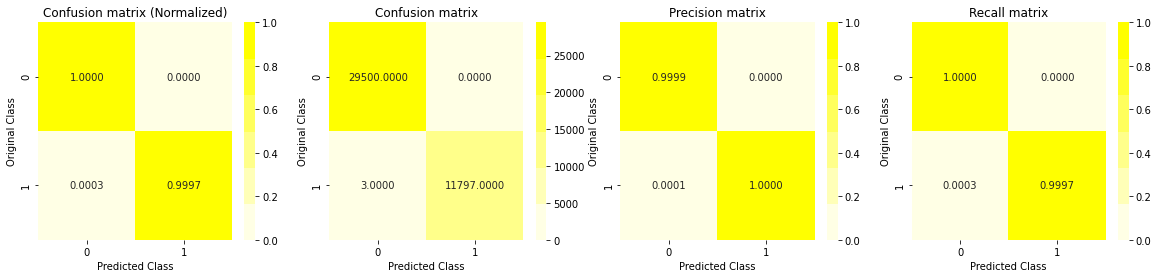



Test Confusion Matrix: 


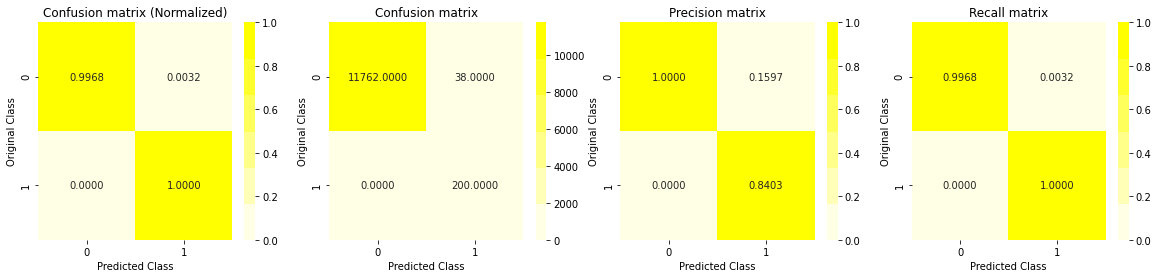

In [ ]:
s_clf = StackingClassifier(estimators = [('lr', logisticR), ('rf', r_clf), ('KNN', KNN)],
                            final_estimator = KNeighborsClassifier(n_jobs=-1),n_jobs=-1,verbose=10)
s_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=s_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = s_clf.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = s_clf.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = s_clf.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
s_clf_c=confusion_mx(y_test,pred_y_test)
s_clf_mcr=((s_clf_c[1][0] +s_clf_c[0][1])/len(y_test))*100



In [ ]:
print('Misclassification rate : ',s_clf_mcr)

Misclassification rate :  0.31666666666666665


###7.6.2. Stacking Classifier with some hyperparameter tuning


F1 score for : 1 is 0.8634686346863468 
F1 score for : 3 is 0.893939393939394 
F1 score for : 5 is 0.8981132075471697 
F1 score for : 7 is 0.898876404494382 
F1 score for : 9 is 0.8921933085501859 
F1 score for : 11 is 0.8921933085501859 
F1 score for : 13 is 0.9056603773584906 

  Best alpha (hyperparameter) : 13 



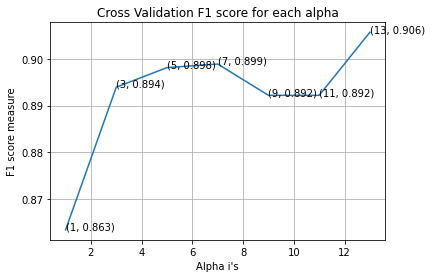


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9998304797423293
F1_score for cv data :  0.9118773946360154
F1_score for test data :  0.9237875288683602



Train Confusion Matrix: 


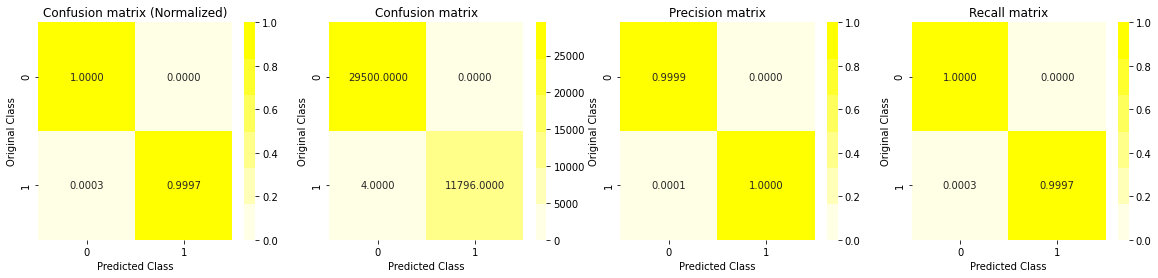



Test Confusion Matrix: 


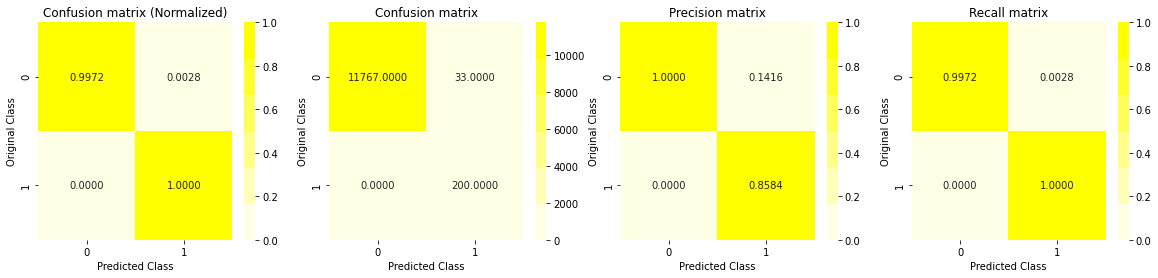

In [ ]:
from sklearn.ensemble import StackingClassifier
#choosing the best hyperparameters
alpha = [x for x in range(1, 15, 2)]
estimators=[('lr', logisticR), ('rf', r_clf), ('KNN', KNN)]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    s_clf = StackingClassifier(estimators = estimators,final_estimator = KNeighborsClassifier(n_neighbors=i,n_jobs=-1),n_jobs=-1,verbose=10)
    s_clf.fit(X_train, y_train)
    predict_y = s_clf.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters    
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_s_clf = np.argmax(cv_f1score_array) 


print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_s_clf]  ,'\n')

#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots() #returning a tuple of fig and axes

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array) 
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
s_clf = StackingClassifier(estimators = estimators,
                           final_estimator = KNeighborsClassifier(n_neighbors=best_alpha_s_clf,n_jobs=-1),n_jobs=-1,verbose=10)
s_clf.fit(X_train, y_train)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = s_clf.predict(X_train)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = s_clf.predict(X_cv)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = s_clf.predict(X_test)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
s_clf_c2=confusion_mx(y_test,pred_y_test)
s_clf_mcr2=((s_clf_c2[1][0] +s_clf_c2[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',s_clf_mcr2)

Misclassification rate :  0.27499999999999997


In [ ]:
# Saving the Model to file 

Pkl_Filename = "/content/drive/My Drive/Self Case study -1/Stack.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(s_clf, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Stack= pickle.load(file)

###7.6.2. Stacking Classifier with Important features


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9995760915642221
F1_score for cv data :  0.9118773946360154
F1_score for test data :  0.9280742459396751



Train Confusion Matrix: 


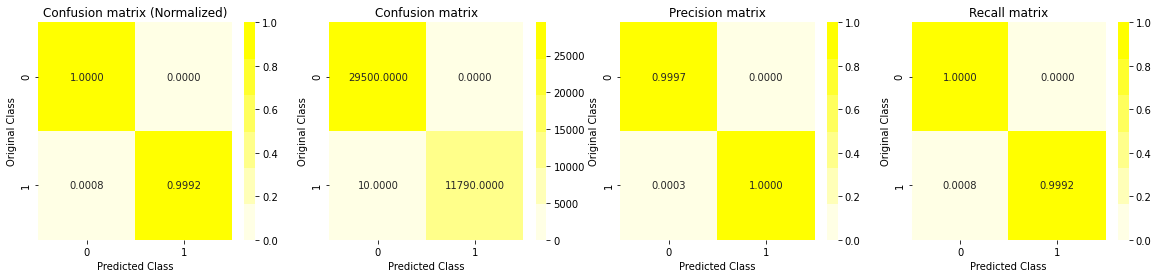



Test Confusion Matrix: 


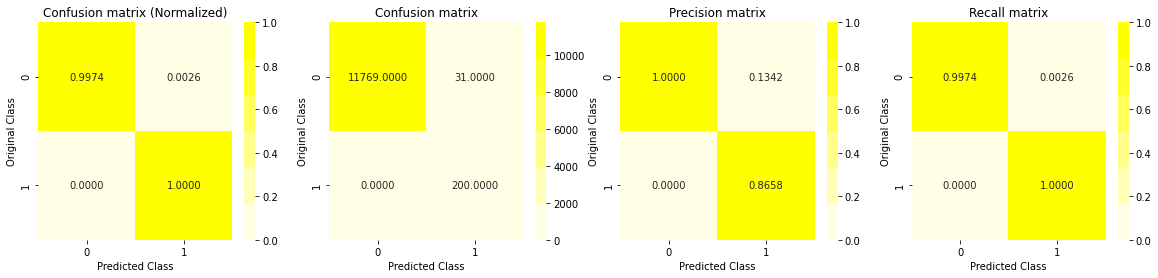

In [ ]:
from sklearn.ensemble import StackingClassifier

#fitting the classifier with best hyperparameter
s_clf_i = StackingClassifier(estimators = estimators,
                           final_estimator = KNeighborsClassifier(n_neighbors=best_alpha_s_clf,n_jobs=-1),n_jobs=-1,verbose=10)
s_clf_i.fit(X_tr_rf, y_train)


#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = s_clf_i.predict(X_tr_rf)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = s_clf_i.predict(X_cv_rf)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = s_clf_i.predict(X_te_rf)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
s_clf_c_i=confusion_mx(y_test,pred_y_test)
s_clf_mcr_i=((s_clf_c_i[1][0] +s_clf_c_i[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',s_clf_mcr_i)

Misclassification rate :  0.2583333333333333


### 7.5. XGBoost Classification :

In [ ]:
from collections import Counter
c1=Counter(y_train)
c=c1[0]/c1[1]


F1 score for : 10 is 0.4763948497854077 
F1 score for : 50 is 0.5670886075949367 
F1 score for : 100 is 0.6267806267806267 
F1 score for : 500 is 0.8888888888888888 
F1 score for : 1000 is 0.9266409266409266 

  Best alpha (hyperparameter) : 1000 



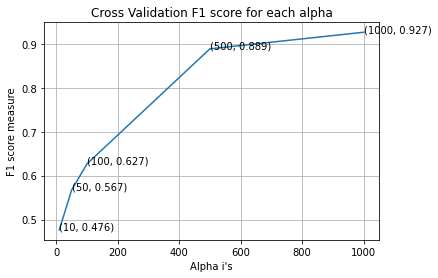


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 0.9999152470548351
F1_score for cv data 0.9266409266409266
F1_score for test data 0.9324009324009325



Train Confusion Matrix: 


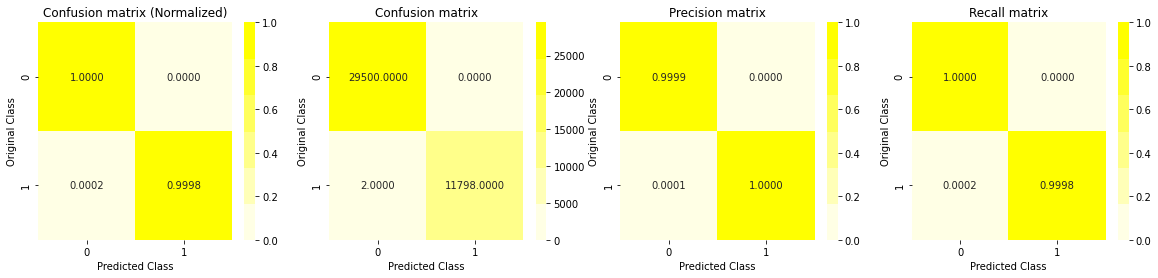



Test Confusion Matrix: 


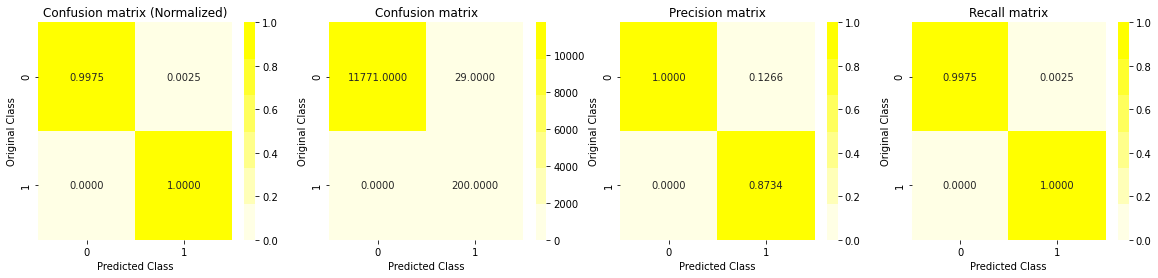

In [ ]:
#choosing the best hyperparameters

alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1,tree_method='gpu_hist',scale_pos_weight=c)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict(X_cv)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_XGB = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_XGB]  ,'\n')
#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha_XGB],nthread=-1,tree_method='gpu_hist',scale_pos_weight=c)
x_cfl.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

#predicting actual labels
pred_y=sig_clf.predict(X_test)

#displaying the perfomance metric for train,cv and test data

print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf.predict(X_train)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf.predict(X_cv)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf.predict(X_test)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
XGB_c=confusion_mx(y_test,pred_y_test)
XGB_mcr=((XGB_c[1][0] +XGB_c[0][1])/len(y_test))*100

In [ ]:
print('Misclassification rate : ',XGB_mcr)

Misclassification rate :  0.24166666666666667


In [ ]:
# Saving the Model to file 

Pkl_Filename = "/content/drive/My Drive/Self Case study -1/XGBoost.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(sig_clf, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    XGBoost= pickle.load(file)


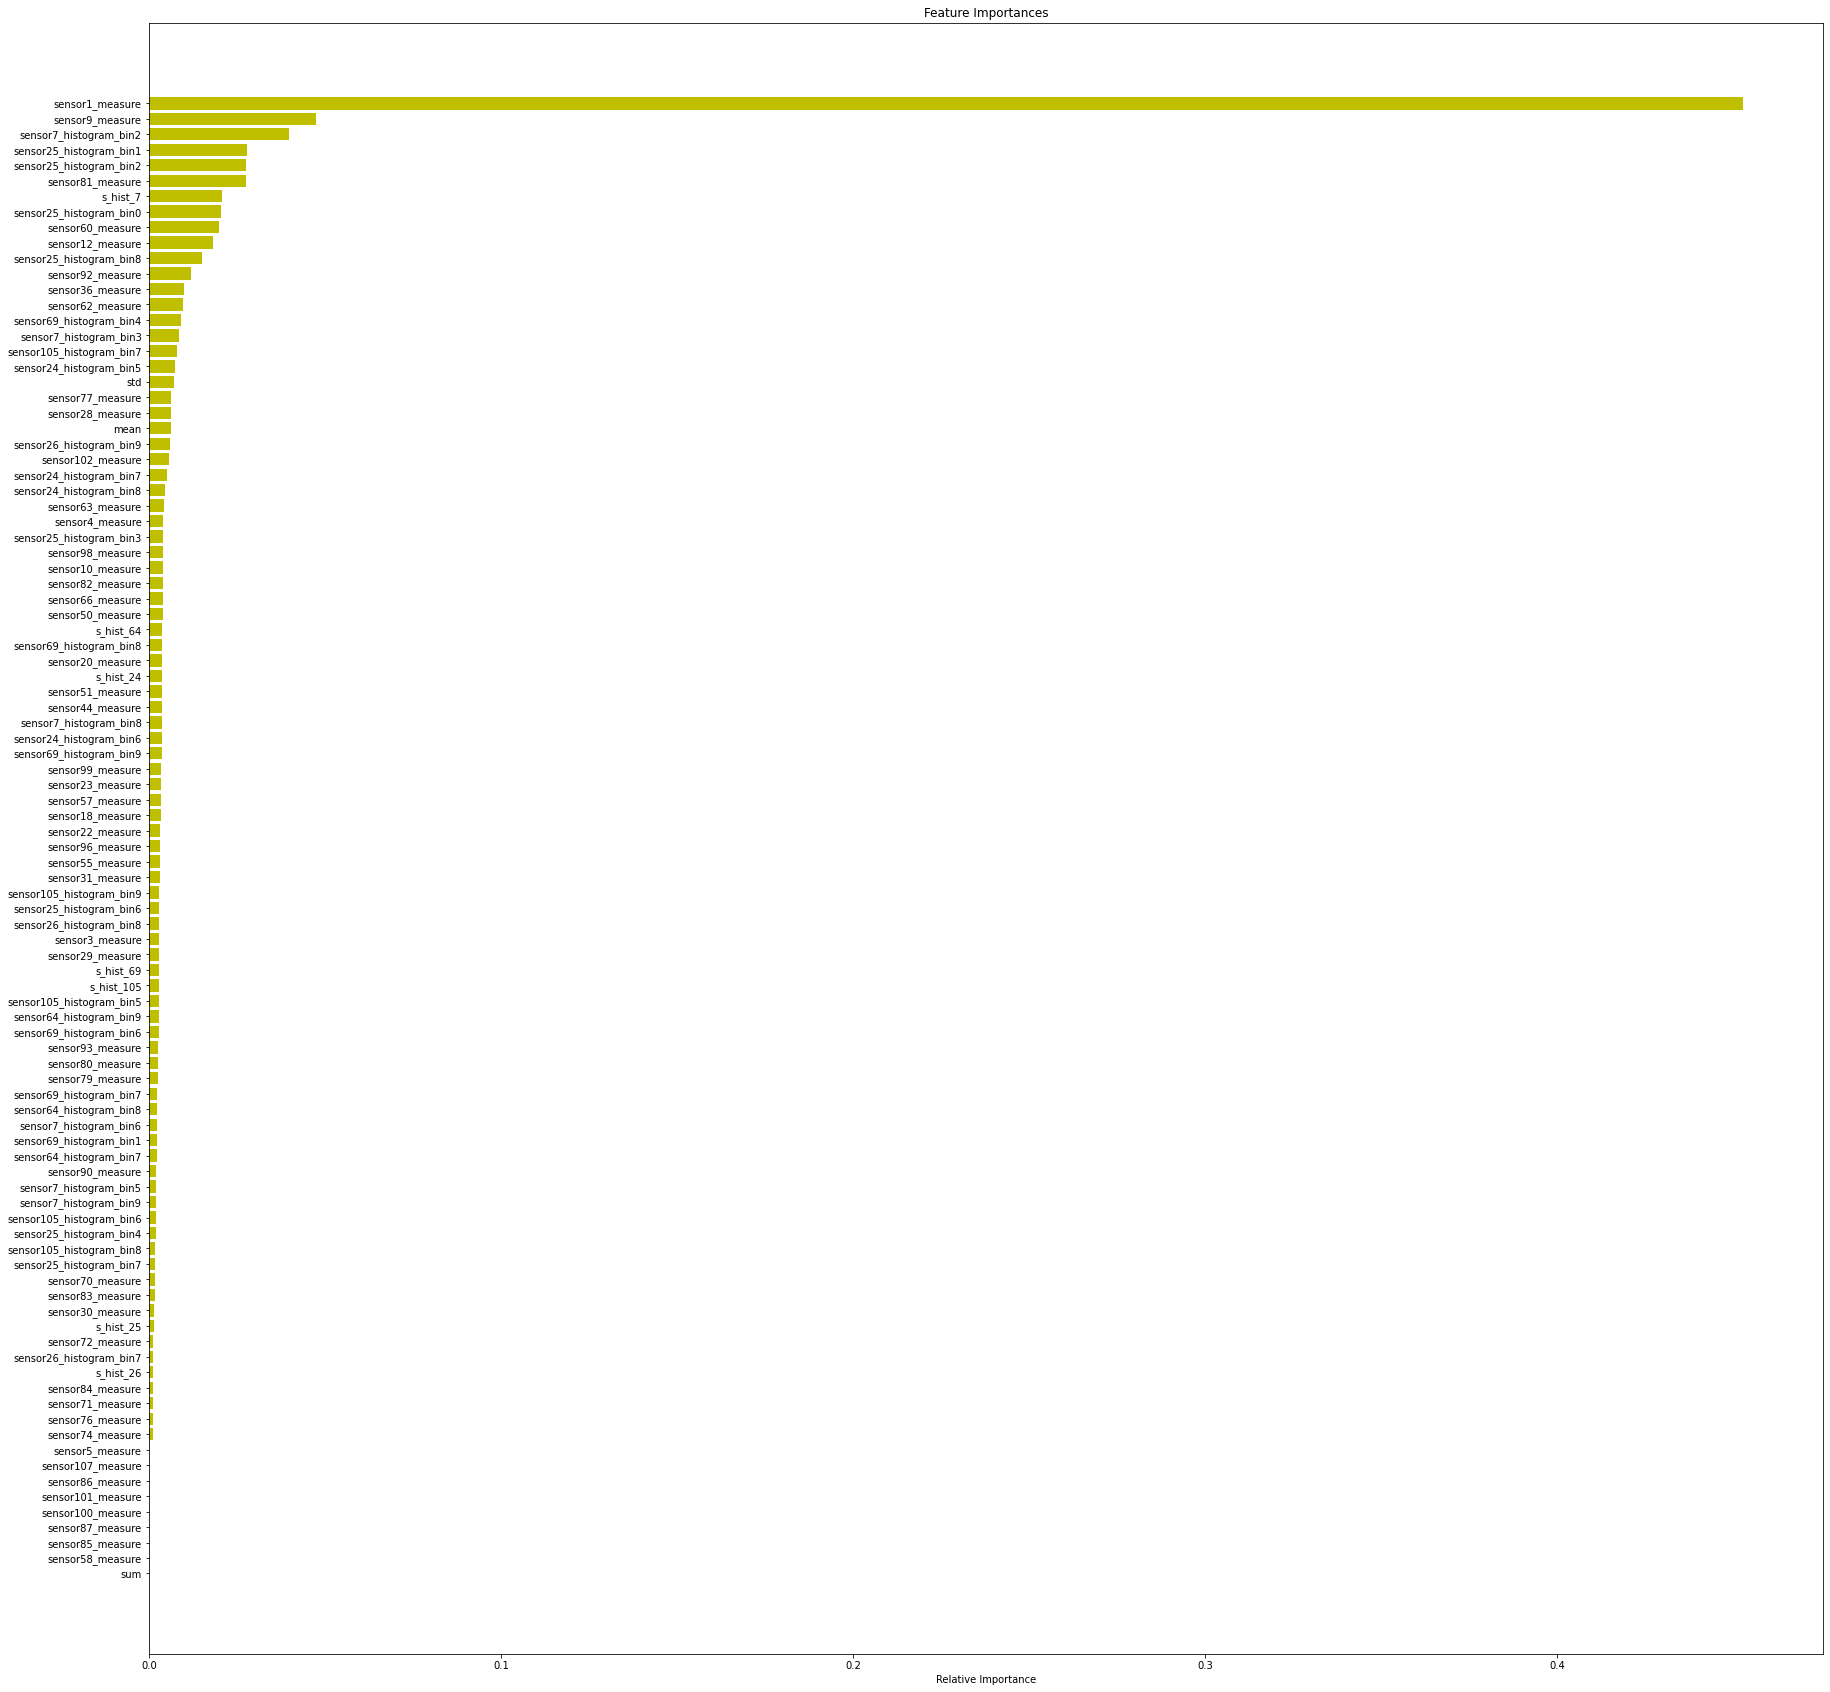

In [ ]:
#feature importance
features = X_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize=(30,30))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='y', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- Checking if any feature has zero importance in the modelling.

In [ ]:
importances = x_cfl.feature_importances_
c=0
for i in importances:
    if i==0:
        c+=1
print('The no. features which have 0 feature importance : ',c)

The no. features which have 0 feature importance :  9


- Removing the least 40 importance features 

In [ ]:
features = X_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[:40]
rem_feat=[]
for i in indices:
    rem_feat.append(features[i]) 

#removing the least important features.
X_tr_XGB=X_train.drop(rem_feat,axis=1)
X_cv_XGB=X_cv.drop(rem_feat,axis=1)
X_te_XGB=X_test.drop(rem_feat,axis=1)

In [ ]:
X_tr_XGB.to_csv('/content/drive/My Drive/Self Case study -1/X_tr_XGB.csv',index=False,index_label=False)
X_cv_XGB.to_csv('/content/drive/My Drive/Self Case study -1/X_cv_XGB.csv',index=False,index_label=False)
X_te_XGB.to_csv('/content/drive/My Drive/Self Case study -1/X_te_XGB.csv',index=False,index_label=False)

###7.5.1. Stacking with important features of XGBoost


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data :  0.9999576253231068
F1_score for cv data :  0.9195402298850576
F1_score for test data :  0.9153318077803204



Train Confusion Matrix: 


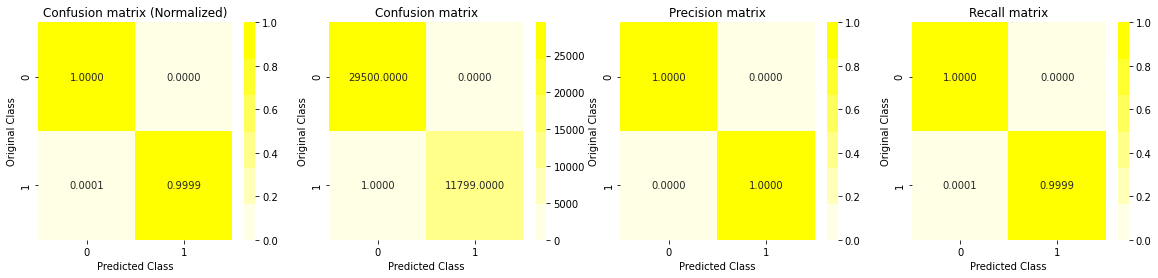



Test Confusion Matrix: 


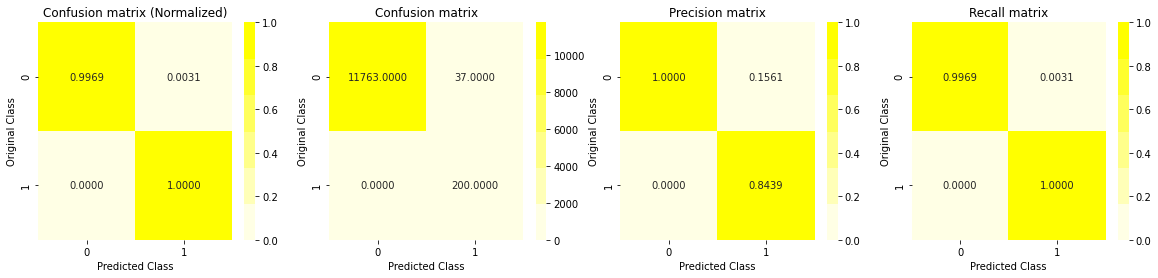

In [ ]:
from sklearn.ensemble import StackingClassifier

#fitting the classifier with best hyperparameter
s_clf_XGB = StackingClassifier(estimators = estimators,
                           final_estimator = KNeighborsClassifier(n_neighbors=13,n_jobs=-1),n_jobs=-1,verbose=10)
s_clf_XGB.fit(X_tr_XGB, y_train)


#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train = s_clf_XGB.predict(X_tr_XGB)
print ('F1 score for train data : ',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = s_clf_XGB.predict(X_cv_XGB)
print ('F1_score for cv data : ',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = s_clf_XGB.predict(X_te_XGB)
print ('F1_score for test data : ',f1_score(y_test, pred_y_test, average='binary'))


#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
s_clf_c_XGB=confusion_mx(y_test,pred_y_test)
s_clf_mcr_XGB=((s_clf_c_XGB[1][0] +s_clf_c_XGB[0][1])/len(y_test))*100

In [ ]:
# Saving the Model to file 

Pkl_Filename = "/content/drive/My Drive/Self Case study -1/Stack_imp.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(s_clf_XGB, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Stack_imp= pickle.load(file)


In [ ]:
print('Missclassification Rate : ',s_clf_mcr_XGB)

Missclassification Rate :  0.30833333333333335


###7.5.1. XGBOOST with important features


F1 score for : 10 is 0.4394250513347022 
F1 score for : 50 is 0.6 
F1 score for : 100 is 0.6646153846153847 
F1 score for : 500 is 0.8957528957528959 
F1 score for : 1000 is 0.9554655870445343 

  Best alpha (hyperparameter) : 1000 



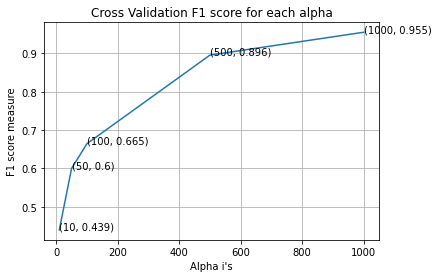


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 0.9991093769879978
F1_score for cv data 0.9554655870445343
F1_score for test data 0.9542168674698797



Train Confusion Matrix: 


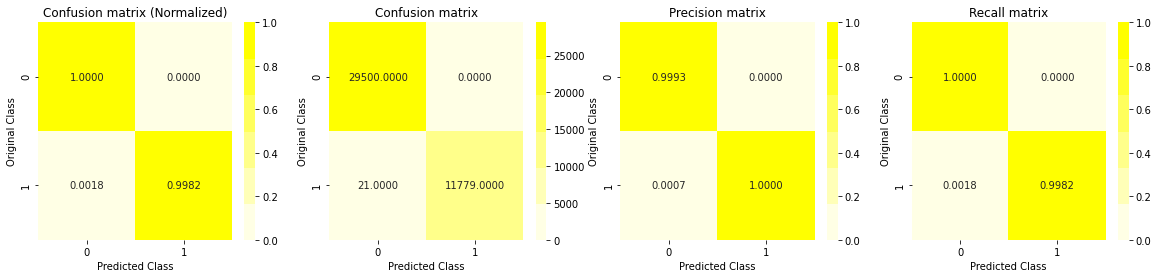



Test Confusion Matrix: 


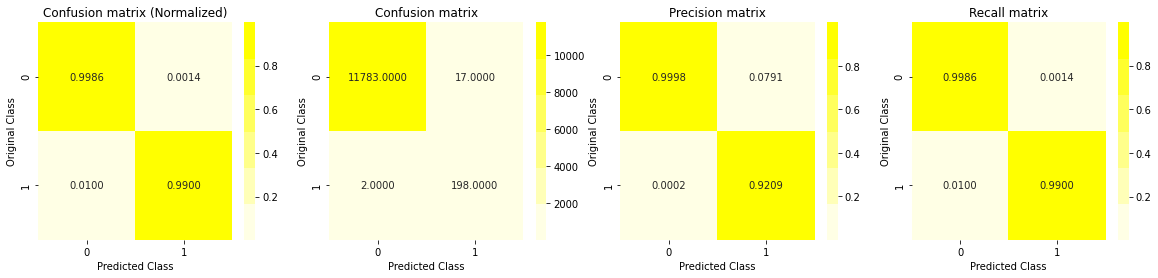

In [ ]:
#choosing the best hyperparameters

alpha=[10,50,100,500,1000]

#storing the f1 score for all hyperparameters in an array
cv_f1score_array=[]
for i in tqdm(alpha):
    x_cfl_i=XGBClassifier(n_estimators=i,nthread=-1,tree_method='gpu_hist',scale_pos_weight=c)
    x_cfl_i.fit(X_tr_XGB,y_train)
    sig_clf_i = CalibratedClassifierCV(x_cfl_i, method="isotonic")
    sig_clf_i.fit(X_tr_XGB, y_train)
    predict_y = sig_clf_i.predict(X_cv_XGB)
    cv_f1score_array.append(f1_score(y_cv, predict_y,average='binary'))

#displaying the F1 score for all hyperparameters      
for i in range(len(cv_f1score_array)):
    print ('F1 score for : {} is {} '.format(alpha[i],cv_f1score_array[i]))

#best hyperparameter
best_alpha_XGBi = np.argmax(cv_f1score_array)

print( '\n  Best alpha (hyperparameter) :',alpha[best_alpha_XGBi]  ,'\n')
#plotting the changes of the performance metric with best hyperparameter
fig, ax = plt.subplots()

#plotting hyperparameter V/S F1score  
ax.plot(alpha, cv_f1score_array)
for i, txt in enumerate(np.round(cv_f1score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_f1score_array[i]))
plt.grid()
plt.title("Cross Validation F1 score for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("F1 score measure")
plt.show()

#fitting the classifier with best hyperparameter
x_cfl_i=XGBClassifier(n_estimators=alpha[best_alpha_XGBi],nthread=-1,tree_method='gpu_hist',scale_pos_weight=c)
x_cfl_i.fit(X_tr_XGB, y_train)
sig_clf_i = CalibratedClassifierCV(x_cfl_i, method="isotonic")
sig_clf_i.fit(X_tr_XGB, y_train)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf_i.predict(X_tr_XGB)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf_i.predict(X_cv_XGB)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf_i.predict(X_te_XGB)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
XGB_c_i=confusion_mx(y_test,pred_y_test)
XGB_mcr_i=((XGB_c_i[1][0] +XGB_c_i[0][1])/len(y_test))*100

In [ ]:
print('\n \n Misclassification rate : ',XGB_mcr_i)


 
 Misclassification rate :  0.15833333333333333


In [ ]:
# Saving the Model to file 

Pkl_Filename = "/content/drive/My Drive/Self Case study -1/XGBoost_imp.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(sig_clf_i, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    XGBoost_imp= pickle.load(file)


####7.5.2 XGBOOST with best hyperparameter search using RandomSearchCV

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl_h=XGBClassifier(tree_method='gpu_hist',scale_pos_weight=c)

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl_h,param_distributions=prams,n_jobs=-1,cv=3)
random_cfl1.fit(X_train,y_train)

In [ ]:
print (random_cfl1.best_params_)                                                        

{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.15, 'colsample_bytree': 0.3}


- some manual hyperparameter tuning  is done.


 Predicting F1 score for train,cv and test data with best hyperparameter 

F1 score for train data 0.9999152470548351
F1_score for cv data 0.9561752988047809
F1_score for test data 0.9501187648456058



Train Confusion Matrix: 


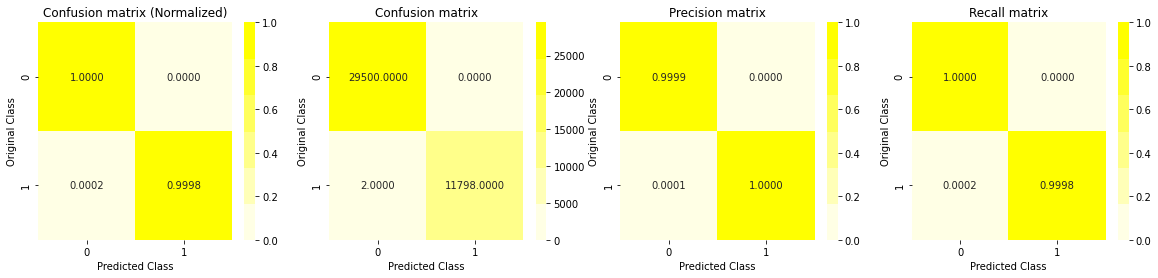



Test Confusion Matrix: 


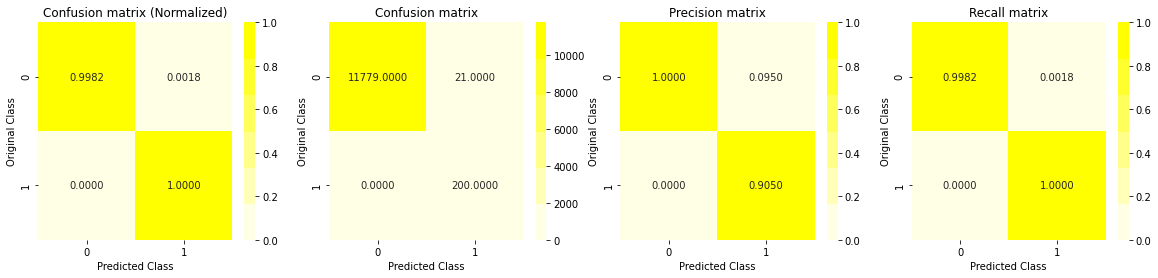


 
 Misclassification rate :  0.17500000000000002


In [ ]:
#fitting the classifier with best hyperparameter
x_cfl_h=XGBClassifier(n_estimators=1000,subsample=1,max_depth=6,learning_rate=0.3,colsample_bytree=1,tree_method='gpu_hist',scale_pos_weight=c)
x_cfl_h.fit(X_train, y_train)
sig_clf_h = CalibratedClassifierCV(x_cfl_h, method="isotonic")
sig_clf_h.fit(X_train, y_train)

#displaying the perfomance metric for train,cv and test data
print('\n Predicting F1 score for train,cv and test data with best hyperparameter \n')
pred_y_train =sig_clf_h.predict(X_train)
print ('F1 score for train data',f1_score(y_train, pred_y_train,average='binary' ))
pred_y_cv = sig_clf_h.predict(X_cv)
print ('F1_score for cv data',f1_score(y_cv, pred_y_cv, average='binary'))
pred_y_test = sig_clf_h.predict(X_test)
print ('F1_score for test data',f1_score(y_test, pred_y_test, average='binary'))

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,pred_y_train)
print('\n')
print('Test Confusion Matrix: ')
XGB_c_h=confusion_mx(y_test,pred_y_test)
XGB_mcr_h=((XGB_c_h[1][0] +XGB_c_h[0][1])/len(y_test))*100 #misclassification rate
print('\n \n Misclassification rate : ',XGB_mcr_h)

### 8. Interim Summary :


In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Model","Hyperparameter","Hyperparameter value","Train F1 score","Test F1 Score",'Misclassification rate']
x.add_row([ "kNN", 'alpha',1,'1.0','0.804','0.808'])
x.add_row([ "Logistic Regression", 'C',100 ,'0.910','0.665','1.400'])
x.add_row([ "SVM", 'alpha', 0.1,'0.729','0.534','2.091'])
x.add_row([ "Random Forest", 'n_estimators',10, '0.999','0.865','0.516'])
x.add_row([ "Random Forest with Imp. Feat.", 'n_estimators',10, '0.999','0.879','0.458'])
x.add_row([ "Voting Classifier", 'Models','[LR,KNN,RF]', '0.999','0.8333','0.666'])
x.add_row([ "Voting Classifier with Imp. Feat.", 'Models','[LR,KNN,RF]', '0.999','0.835','0.658'])
x.add_row([ "Stacking Classifier", 'Models','[LR,KNN,RF/KNN(5)]', '0.999','0.913','0.316'])
x.add_row([ "Stacking Classifier", 'Models','[LR,KNN,RF/KNN(13)]', '0.999','0.923','0.274'])
x.add_row([ "Stacking Classifier with Imp. Feat.", 'Models','[LR,KNN,RF/KNN(13)]', '0.999','0.928','0.258'])
x.add_row(["XGboost",'n_estimators',1000,'0.999','0.932','0.241'])
x.add_row([ "Stacking Classifier with Imp. Feat. (XGBoost)", 'Models','[LR,KNN,RF/KNN(13)]', '0.999','0.915','0.308'])
x.add_row(["XGboost with Imp. Feat.",'n_estimators',1000,'0.999','0.954','0.158'])
x.add_row(["XGboost with best hyperparameter using RS",'n_estimators',1000,'0.999','0.950','0.175'])
print(x)

+-----------------------------------------------+----------------+----------------------+----------------+---------------+------------------------+
|                     Model                     | Hyperparameter | Hyperparameter value | Train F1 score | Test F1 Score | Misclassification rate |
+-----------------------------------------------+----------------+----------------------+----------------+---------------+------------------------+
|                      kNN                      |     alpha      |          1           |      1.0       |     0.804     |         0.808          |
|              Logistic Regression              |       C        |         100          |     0.910      |     0.665     |         1.400          |
|                      SVM                      |     alpha      |         0.1          |     0.729      |     0.534     |         2.091          |
|                 Random Forest                 |  n_estimators  |          10          |     0.999      |     0

Models which are working best :
- XGBoost 
- Stacking Classifier  

###9. Weighted Average Ensemble Model(With Imp. Feat.)

F1 score for train data 0.9998728651947282
F1_score for test data 0.954653937947494



Train Confusion Matrix: 


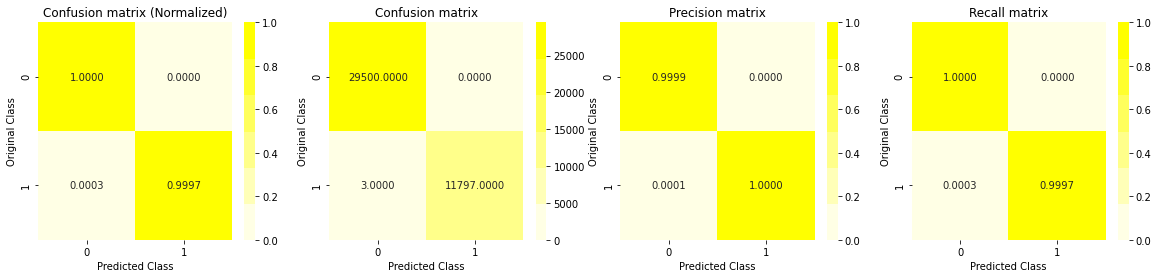



Test Confusion Matrix: 


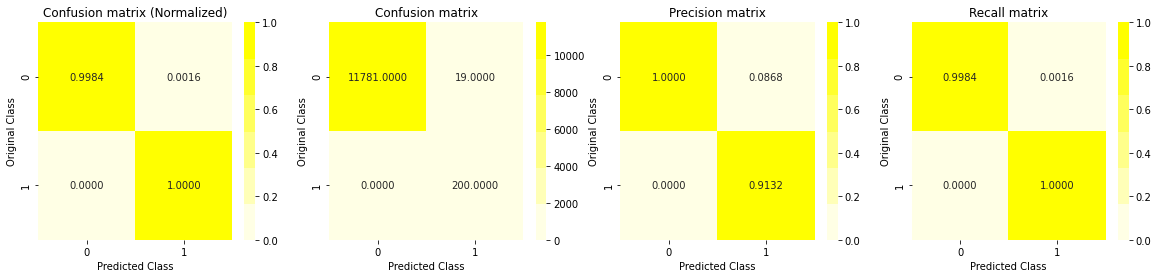


 
 Misclassification rate :  0.15833333333333333


In [ ]:
#for i in len(X_te_)
pp_XGB=(XGBoost_imp.predict_proba(X_te_XGB))
pp_XGB_t=(XGBoost_imp.predict_proba(X_tr_XGB))

pp_Stack=Stack_imp.predict_proba(X_te_XGB)
pp_Stack_t=Stack_imp.predict_proba(X_tr_XGB)

y_p=[]
for i in range(len(X_te_XGB)):
    z=(0.7*pp_XGB[i][0]+0.3*pp_Stack[i][0])/2
    o=(0.7*pp_XGB[i][1]+0.3*pp_Stack[i][1])/2
    if z>o:
        y_p.append(0)
    else: y_p.append(1)

y_t=[]
for i in range(len(X_tr_XGB)):
    z=(0.7*pp_XGB_t[i][0]+0.7*pp_Stack_t[i][0])/2
    o=(0.7*pp_XGB_t[i][1]+0.7*pp_Stack_t[i][1])/2
    if z>o:
        y_t.append(0)
    else: y_t.append(1)



print ('F1 score for train data',f1_score(y_train, y_t,average='binary' ))
print ('F1_score for test data',f1_score(y_test, y_p, average='binary'))

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,y_t)
print('\n')
print('Test Confusion Matrix: ')
avg=confusion_mx(y_test,y_p)
avg_mcr=((avg[1][0] +avg[0][1])/len(y_test))*100 #misclassification rate
print('\n \n Misclassification rate : ',avg_mcr)

####9.1. Weighted Average Ensemble Model(Without Imp. Feat.)

F1 score for train data 1.0
F1_score for test data 0.9324009324009325



Train Confusion Matrix: 


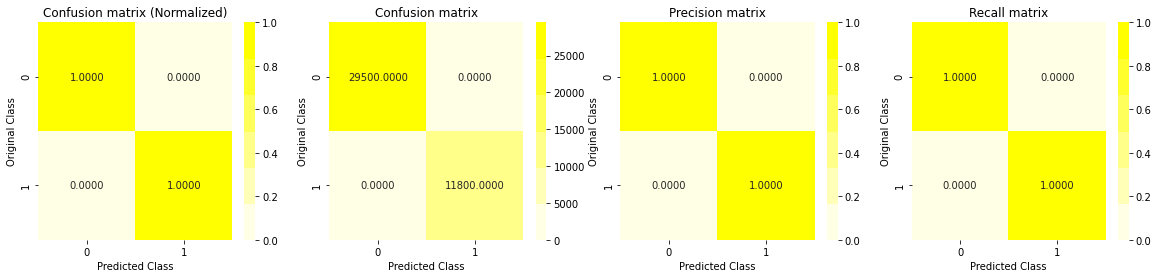



Test Confusion Matrix: 


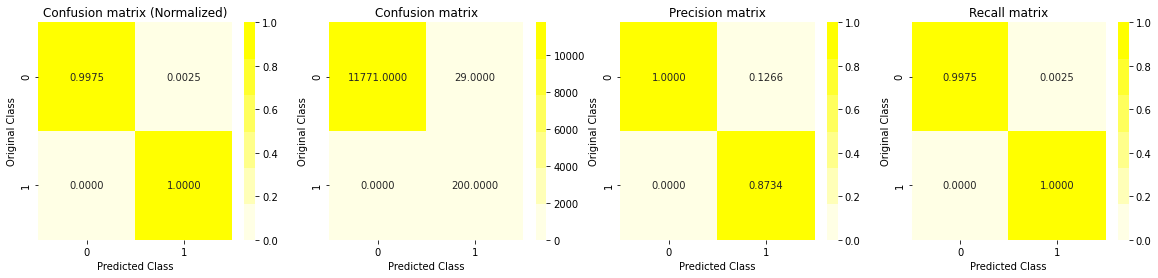


 
 Misclassification rate :  0.24166666666666667


In [ ]:
#for i in len(X_te_)
p_XGB=(XGBoost.predict_proba(X_test))
p_XGB_t=(XGBoost.predict_proba(X_train))

p_Stack=Stack.predict_proba(X_test)
p_Stack_t=Stack.predict_proba(X_train)

y_p=[]
for i in range(len(X_test)):
    z=(0.7*p_XGB[i][0]+0.3*p_Stack[i][0])/2
    o=(0.7*p_XGB[i][1]+0.3*p_Stack[i][1])/2
    if z>o:
        y_p.append(0)
    else: y_p.append(1)

y_t=[]
for i in range(len(X_train)):
    z=(0.7*p_XGB_t[i][0]+0.7*p_Stack_t[i][0])/2
    o=(0.7*p_XGB_t[i][1]+0.7*p_Stack_t[i][1])/2
    if z>o:
        y_t.append(0)
    else: y_t.append(1)



print ('F1 score for train data',f1_score(y_train, y_t,average='binary' ))
print ('F1_score for test data',f1_score(y_test, y_p, average='binary'))

#funct. to plot confusion matrix
print('\n\n')
print('Train Confusion Matrix: ')
confusion_mx(y_train,y_t)
print('\n')
print('Test Confusion Matrix: ')
avg2=confusion_mx(y_test,y_p)
avg_mcr2=((avg2[1][0] +avg2[0][1])/len(y_test))*100 #misclassification rate
print('\n \n Misclassification rate : ',avg_mcr2)

###10. Final Summary

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Model","Hyperparameter","Hyperparameter value","Train F1 score","Test F1 Score",'Misclassification rate']
x.add_row([ "kNN", 'alpha',1,'1.0','0.804','0.808'])
x.add_row([ "Logistic Regression", 'C',100 ,'0.910','0.665','1.400'])
x.add_row([ "SVM", 'alpha', 0.1,'0.729','0.534','2.091'])
x.add_row([ "Random Forest", 'n_estimators',10, '0.999','0.865','0.516'])
x.add_row([ "Random Forest with Imp. Feat.", 'n_estimators',10, '0.999','0.879','0.458'])
x.add_row([ "Voting Classifier", 'Models','[LR,KNN,RF]', '0.999','0.8333','0.666'])
x.add_row([ "Voting Classifier with Imp. Feat.", 'Models','[LR,KNN,RF]', '0.999','0.835','0.658'])
x.add_row([ "Stacking Classifier", 'Models','[LR,KNN,RF/KNN(5)]', '0.999','0.913','0.316'])
x.add_row([ "Stacking Classifier", 'Models','[LR,KNN,RF/KNN(13)]', '0.999','0.923','0.274'])
x.add_row([ "Stacking Classifier with Imp. Feat.", 'Models','[LR,KNN,RF/KNN(13)]', '0.999','0.928','0.258'])
x.add_row(["XGboost",'n_estimators',1000,'0.999','0.932','0.241'])
x.add_row(["XGboost with best hyperparameter using RS",'n_estimators',1000,'0.999','0.950','0.175'])
x.add_row([ "Stacking Classifier with Imp. Feat. (XGBoost)", 'Models','[LR,KNN,RF/KNN(13)]', '0.999','0.915','0.308'])
x.add_row(["XGboost with Imp. Feat.",'n_estimators',1000,'0.999','0.954','0.158'])
x.add_row([ "Weighted Average Ensemble without Feat. Imp.", 'Models','[Stacking,XGBoost]', '1.0','0.932','0.241'])
x.add_row([ "Weighted Average Ensemble with Feat. Imp.", 'Models','[Stacking,XGBoost]', '0.999','0.954','0.158'])

print(x)

+-----------------------------------------------+----------------+----------------------+----------------+---------------+------------------------+
|                     Model                     | Hyperparameter | Hyperparameter value | Train F1 score | Test F1 Score | Misclassification rate |
+-----------------------------------------------+----------------+----------------------+----------------+---------------+------------------------+
|                      kNN                      |     alpha      |          1           |      1.0       |     0.804     |         0.808          |
|              Logistic Regression              |       C        |         100          |     0.910      |     0.665     |         1.400          |
|                      SVM                      |     alpha      |         0.1          |     0.729      |     0.534     |         2.091          |
|                 Random Forest                 |  n_estimators  |          10          |     0.999      |     0